<a href="https://colab.research.google.com/github/rohitrrk22/Brain_Tumor_Classification/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Classification

## Clone the Github Repo to access the Dataset

In [1]:
!git clone https://github.com/Ashish-Arya-CS/Coursera-Content.git

Cloning into 'Coursera-Content'...
remote: Enumerating objects: 3049, done.
remote: Counting objects: 100% (3049/3049), done.
remote: Compressing objects: 100% (3046/3046), done.
remote: Total 3049 (delta 1), reused 3043 (delta 0), pack-reused 0
Receiving objects: 100% (3049/3049), 79.25 MiB | 11.12 MiB/s, done.
Resolving deltas: 100% (1/1), done.


## Import necessary Libraries 

In [2]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,ImageDataGenerator, array_to_img
from tensorflow.keras.applications import EfficientNetB1

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Dropout,GlobalAveragePooling2D

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
import imutils    


## Creating Directories to store Cropped Images

In [3]:
# Create Directory for Training Data
os.mkdir("/content/Crop_Brain_MRI")
os.mkdir("/content/Crop_Brain_MRI/glioma_tumor")
os.mkdir("/content/Crop_Brain_MRI/meningioma_tumor")
os.mkdir("/content/Crop_Brain_MRI/no_tumor")
os.mkdir("/content/Crop_Brain_MRI/pituitary_tumor")

In [4]:
# Create Directory for Testing Data

os.mkdir("/content/Crop_Brain_MRI_Test")
os.mkdir("/content/Crop_Brain_MRI_Test/glioma_tumor")
os.mkdir("/content/Crop_Brain_MRI_Test/meningioma_tumor")
os.mkdir("/content/Crop_Brain_MRI_Test/no_tumor")
os.mkdir("/content/Crop_Brain_MRI_Test/pituitary_tumor")

## Data Visualization

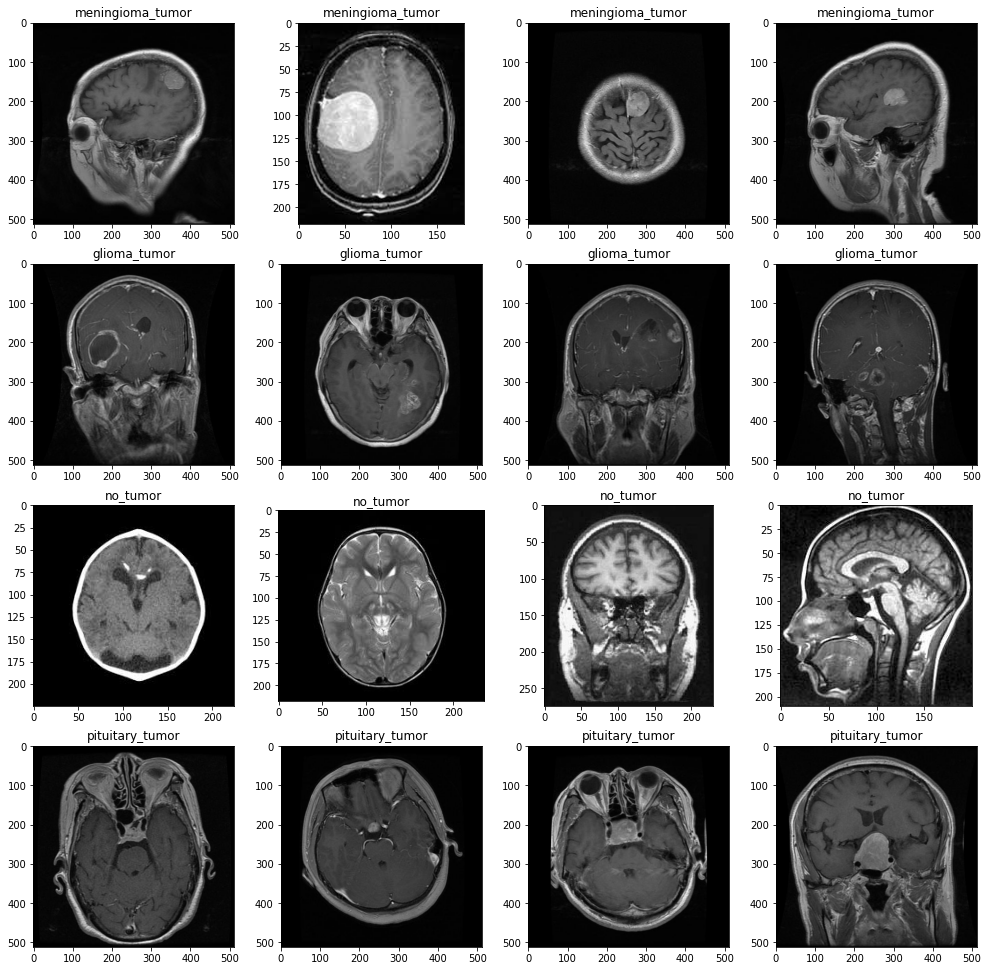

In [5]:
train_dir = "/content/Coursera-Content/Brain-MRI/Training/"
test_dir = "/content/Coursera-Content/Brain-MRI/Testing/"
classes = os.listdir("/content/Coursera-Content/Brain-MRI/Training")
files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x :train_dir+c+'/'+x,os.listdir(train_dir+c)))


plt.figure(figsize=(17,17))
index=0

for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range(1,5):
    index += 1
    plt.subplot(4,4,index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

## Create a Function to Crop Images

In [6]:
def crop_image(image, plot=False):
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  ##converting color img to grayscale img
    img_gray = cv2.GaussianBlur(img_gray, (5, 5), 0)    #Bluring the image
    
    img_thresh = cv2.threshold(img_gray, 45, 255, cv2.THRESH_BINARY)[1]  #binary thresholding -replacing pixel value greater that 45 to 255 & less than 45 value to 0
    img_thresh = cv2.erode(img_thresh, None, iterations=2)   #applying erosion on the img i.e.diminishes the features in a img
    img_thresh = cv2.dilate(img_thresh, None, iterations=2)  #dilation - increases size of foreground object(opposite of erode)

    contours = cv2.findContours(img_thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    c = max(contours, key=cv2.contourArea)

    #Positions of contours
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]   #cropping the img on the basis of above positions          

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()
    
    return new_image


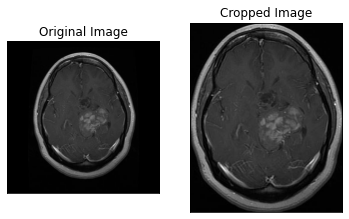

In [7]:
example_img = cv2.imread("/content/Coursera-Content/Brain-MRI/Training/glioma_tumor/gg (1).jpg")
cropped_img = crop_image(example_img,plot=True)

## Saving The Cropped Images 

In [8]:
# Crop the Training Images and Save it to the Directory we previously created
glioma_tumor = train_dir + "glioma_tumor"
meningioma_tumor = train_dir + "meningioma_tumor"
no_tumor = train_dir + "no_tumor"
pituitary_tumor = train_dir + "pituitary_tumor"

j=0
for i in tqdm(os.listdir(glioma_tumor)):          #tqdm - progress bar for showing for loop execution
  path = os.path.join(glioma_tumor,i)  
  img = cv2.imread(path)
  img = crop_image(img,plot=False)   
  if img is not None:
    img = cv2.resize(img,(224,224))
    save_path = "/content/Crop_Brain_MRI/glioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path,img)
    j = j + 1

j=0
for i in tqdm(os.listdir(meningioma_tumor)):          
  path = os.path.join(meningioma_tumor,i)  
  img = cv2.imread(path)
  img = crop_image(img,plot=False)   
  if img is not None:
    img = cv2.resize(img,(224,224))
    save_path = "/content/Crop_Brain_MRI/meningioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path,img)
    j = j + 1

j=0
for i in tqdm(os.listdir(no_tumor)):          
  path = os.path.join(no_tumor,i)  
  img = cv2.imread(path)
  img = crop_image(img,plot=False)   
  if img is not None:
    img = cv2.resize(img,(224,224))
    save_path = "/content/Crop_Brain_MRI/no_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path,img)
    j = j + 1

j=0
for i in tqdm(os.listdir(pituitary_tumor)):          
  path = os.path.join(pituitary_tumor,i)  
  img = cv2.imread(path)
  img = crop_image(img,plot=False)   
  if img is not None:
    img = cv2.resize(img,(224,224))
    save_path = "/content/Crop_Brain_MRI/pituitary_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path,img)
    j = j + 1

100%|██████████| 901/901 [00:06<00:00, 140.32it/s]


In [9]:
# Crop the Testing Images and Save it to the Directory we previously created

glioma_tumor = test_dir + "glioma_tumor"
meningioma_tumor = test_dir + "meningioma_tumor"
no_tumor = test_dir + "no_tumor"
pituitary_tumor = test_dir + "pituitary_tumor"

j=0
for i in tqdm(os.listdir(glioma_tumor)):          #tqdm - progress bar for showing for loop execution
  path = os.path.join(glioma_tumor,i)  
  img = cv2.imread(path)
  img = crop_image(img,plot=False)   
  if img is not None:
    img = cv2.resize(img,(224,224))
    save_path = "/content/Crop_Brain_MRI_Test/glioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path,img)
    j = j + 1

j=0
for i in tqdm(os.listdir(meningioma_tumor)):          
  path = os.path.join(meningioma_tumor,i)  
  img = cv2.imread(path)
  img = crop_image(img,plot=False)   
  if img is not None:
    img = cv2.resize(img,(224,224))
    save_path = "/content/Crop_Brain_MRI_Test/meningioma_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path,img)
    j = j + 1

j=0
for i in tqdm(os.listdir(no_tumor)):          
  path = os.path.join(no_tumor,i)  
  img = cv2.imread(path)
  img = crop_image(img,plot=False)   
  if img is not None:
    img = cv2.resize(img,(224,224))
    save_path = "/content/Crop_Brain_MRI_Test/no_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path,img)
    j = j + 1

j=0
for i in tqdm(os.listdir(pituitary_tumor)):          
  path = os.path.join(pituitary_tumor,i)  
  img = cv2.imread(path)
  img = crop_image(img,plot=False)   
  if img is not None:
    img = cv2.resize(img,(224,224))
    save_path = "/content/Crop_Brain_MRI_Test/pituitary_tumor/" + str(j) + ".jpg"
    cv2.imwrite(save_path,img)
    j = j + 1

100%|██████████| 5/5 [00:00<00:00, 109.35it/s]


## Perform Data Augmentation and Prepare the Train, Validation and Test Dataset

In [10]:
# Use Image Data Generator to perform this task.
datagen = ImageDataGenerator(rotation_range=10,height_shift_range=0.2,horizontal_flip=True,validation_split=0.2)

train_data = datagen.flow_from_directory("/content/Crop_Brain_MRI/",
                                         target_size=(224,224),
                                         batch_size = 32,
                                         class_mode = 'categorical',
                                         subset = 'training'
                                         )

val_data = datagen.flow_from_directory("/content/Crop_Brain_MRI/",
                                         target_size=(224,224),
                                         batch_size = 32,
                                         class_mode = 'categorical',
                                         subset = 'validation'
                                         )

test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory("/content/Crop_Brain_MRI_Test/",
                                         target_size=(224,224),
                                         class_mode = 'categorical'
                                         )


Found 2613 images belonging to 4 classes.
Found 652 images belonging to 4 classes.
Found 20 images belonging to 4 classes.


In [11]:
# View the class dictionary
print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'no_tumor': 2, 'pituitary_tumor': 3}


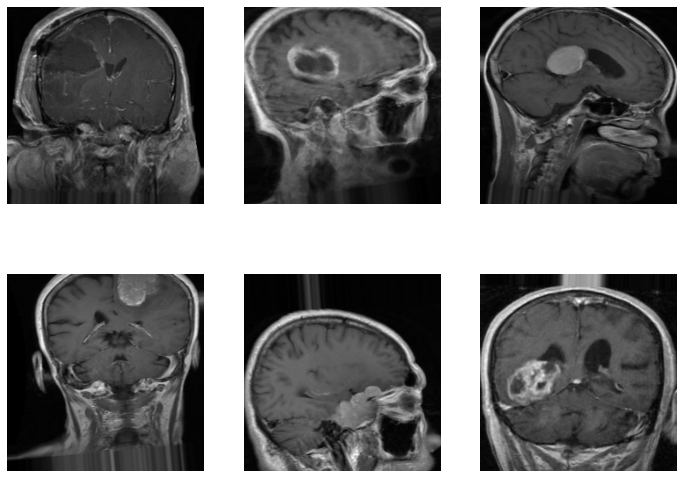

In [12]:
# View the augmented data.
sample_x,sample_y = next(train_data) 
plt.figure(figsize=(12,9))

for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

## Build and Compile the Model 

In [13]:
# Build the Model
effnet = EfficientNetB1(weights="imagenet",include_top=False,input_shape=(224,224,3))

model = effnet.output

model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(4,activation='softmax')(model)
model = Model(inputs=effnet.input,outputs=model)

model.summary()

27025408/27018416 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 224, 224, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 225, 225, 3)  0           normalization[0][0]              
_____________________________

In [14]:
model.compile(optimizer=Adam(learning_rate=0.0001),loss="categorical_crossentropy",metrics=["accuracy"])

checkpoint = ModelCheckpoint("model.h5",monitor="val_accuracy",save_best_only=True,mode="auto",verbose=1)
earlystop = EarlyStopping(monitor="val_accuracy",patience=5,mode="auto",verbose=1) 

## Model Training and Model Evaluation

In [15]:
# Train the model
history = model.fit(train_data,epochs=7,validation_data=val_data,verbose=1,callbacks=[checkpoint,earlystop])

Epoch 1/7
82/82 [==============================] - 122s 945ms/step - loss: 0.8418 - accuracy: 0.6728 - val_loss: 1.0783 - val_accuracy: 0.5890

Epoch 00001: val_accuracy improved from -inf to 0.58896, saving model to model.h5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/7
82/82 [==============================] - 74s 899ms/step - loss: 0.3637 - accuracy: 0.8798 - val_loss: 0.6211 - val_accuracy: 0.7485

Epoch 00002: val_accuracy improved from 0.58896 to 0.74847, saving model to model.h5
Epoch 3/7
82/82 [==============================] - 74s 901ms/step - loss: 0.2193 - accuracy: 0.9250 - val_loss: 0.3974 - val_accuracy: 0.8512

Epoch 00003: val_accuracy improved from 0.74847 to 0.85123, saving model to model.h5
Epoch 4/7
82/82 [==============================] - 75s 910ms/step - loss: 0.1545 - accuracy: 0.9506 - val_loss: 0.2808 - val_accuracy: 0.9095

Epoch 00004: val_accuracy improved from 0.85123 to 0.90951, saving model to model.h5
Epoch 5/7
82/82 [==============================] - 75s 905ms/step - loss: 0.1098 - accuracy: 0.9613 - val_loss: 0.2012 - val_accuracy: 0.9356

Epoch 00005: val_accuracy improved from 0.90951 to 0.93558, saving model to model.h5
Epoch 6/7
82/82 [==============================] - 74s 904ms/step - loss: 0.0968 - accur

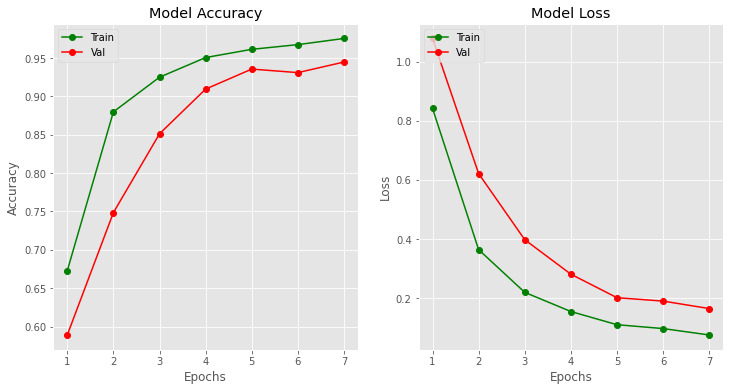

In [16]:
# Plot the training curves
plt.style.use("ggplot")
plt.figure(figsize=(12,6))
epochs = range(1,8)
plt.subplot(1,2,1)
plt.plot(epochs,history.history["accuracy"],"go-")
plt.plot(epochs,history.history["val_accuracy"],"ro-")
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Train","Val"],loc="upper left")

plt.subplot(1,2,2)
plt.plot(epochs,history.history["loss"],"go-")
plt.plot(epochs,history.history["val_loss"],"ro-")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Train","Val"],loc="upper left")

In [17]:
# Evaluate the model on Test Set
model.evaluate(test_data)

1/1 [==============================] - 1s 1s/step - loss: 0.1336 - accuracy: 0.9500


[0.13363537192344666, 0.949999988079071]

## Obtaining Predictions on Test Images

glioma_tumor


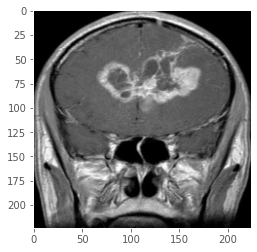

In [18]:
# Obtain Predictions on Test Images
class_dict = {0:'glioma_tumor',1:'meningioma_tumor',2:'no_tumor',3:'pituitary_tumor'}

test_img1 = cv2.imread("/content/Crop_Brain_MRI_Test/glioma_tumor/2.jpg")
plt.imshow(test_img1)
plt.grid(False)
test_img1 = np.expand_dims(test_img1,axis=0)
pred = model.predict(test_img1)
pred = np.argmax(pred)
pred_class = class_dict[pred]
print(pred_class)

meningioma_tumor


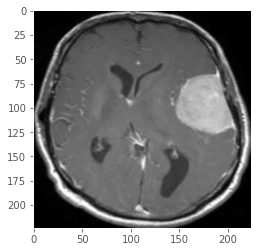

In [19]:
test_img2 = cv2.imread("/content/Crop_Brain_MRI_Test/meningioma_tumor/4.jpg")
plt.imshow(test_img2)
plt.grid(False)
test_img2 = np.expand_dims(test_img2,axis=0)
pred = model.predict(test_img2)
pred = np.argmax(pred)
pred_class = class_dict[pred]
print(pred_class)

no_tumor


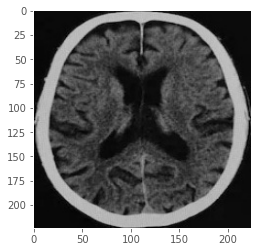

In [20]:
test_img3 = cv2.imread("/content/Crop_Brain_MRI_Test/no_tumor/0.jpg")
plt.imshow(test_img3)
plt.grid(False)
test_img3 = np.expand_dims(test_img3,axis=0)
pred = model.predict(test_img3)
pred = np.argmax(pred)
pred_class = class_dict[pred]
print(pred_class)

pituitary_tumor


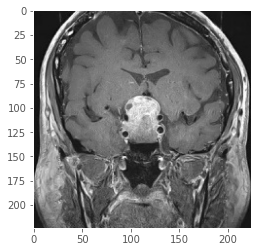

In [21]:
test_img4 = cv2.imread("/content/Crop_Brain_MRI_Test/pituitary_tumor/3.jpg")
plt.imshow(test_img4)
plt.grid(False)
test_img4 = np.expand_dims(test_img4,axis=0)
pred = model.predict(test_img4)
pred = np.argmax(pred)
pred_class = class_dict[pred]
print(pred_class)